# Реализация симуляции

In [1]:
''' 
This code works as simulator.
Main values: brightness, time, date, temperature, humidity.
Users values: message.
'''
import random
import datetime
import time
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.animation as animation

################################## PLANT SETTINGS ##################################
plant_last_watering_day = "2021-01-12"
plant_watering_range_days = 7
plant_temperature = [20, 25]
plant_light_level = 700

plant_temp_limit = 5
plant_light_limit = 400
################################## SYSTEM SETTINGS ##################################
set_lamp = 0
set_pump = 0

data = []
delay = 0.1

################################## HELPER FUNCTIONS ##################################
def generate_value(value, coef, step, roundation):
    real_coef = random.uniform(coef - step, coef + step)
    current_value = value * real_coef
    return round(current_value, roundation)

def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.strptime(d2, "%Y-%m-%d")
    return abs((d2 - d1).days)

def switcher(current_state, new_state):
    exit_code = 1
    if current_state == 1 and new_state == 1:
        exit_code = 0
    if current_state == 0 and new_state == 0:
        exit_code = 0
    return exit_code

def check_state(current_temperature, current_brightness, current_humidity):
    ans = 1
    now = datetime.now()
    current_date = now.strftime("%Y-%m-%d")
    
    if current_brightness < (plant_light_level - plant_light_limit) or current_brightness > (plant_light_level + plant_light_limit):
        ans *= 0
    if current_humidity < 20:
        ans *= 0
    if current_temperature < (plant_temperature[0] - plant_temp_limit) or current_temperature > (plant_temperature[1] + plant_temp_limit):
        ans *= 0
    return ans

def main(lamp_state, pump_state, current_temperature, current_humidity, current_brightness, plant_last_watering_day, addition):
    phrase = ""
    now = datetime.now()
    current_date = now.strftime("%Y-%m-%d")
    current_time = now.strftime("%H:%M:%S")
    
    while(check_state(current_temperature, current_brightness, current_humidity) == 0):
        # lighting
        if current_brightness < plant_light_level and lamp_state == 0:
            print("Admin: Checking the light")
            if switcher(lamp_state, 1) != 0:
                lamp_state = 1
                print("Admin: Lamp is working")
                func = add_light(current_temperature, current_humidity, current_brightness)
                current_temperature = func[0]
                current_humidity = func[2]
                current_brightness = func[1]
                switcher(lamp_state, 0)
                lamp_state = 0
            else:
                print("Error: Lamp is not active")
        
        # watering
        if days_between(plant_last_watering_day, current_date) >= plant_watering_range_days or current_humidity < 20:
            print("Adming: Checking the water")
            if switcher(pump_state, 1) != 0:
                pump_state = 1
                print("Admin: Pump is working")
                plant_last_watering_day = current_date
                func = add_water(current_temperature, current_humidity, current_brightness)
                current_temperature = func[0]
                current_humidity = func[2]
                current_brightness = func[1]
                switcher(pump_state, 0)
                pump_state = 0
            else:
                print("Error: Pump is not active")
        
        # temperature
        if current_temperature < plant_temperature[0] - 5:
            print("It's too cold for your plant, replace it.")
            current_temperature = to_normal(10, current_temperature, current_humidity, current_brightness, 0.03)[0]
            current_humidity = to_normal(10, current_temperature, current_humidity, current_brightness, 0.03)[2]
            current_brightness = to_normal(10, current_temperature, current_humidity, current_brightness, 0.03)[1]
        elif current_temperature > plant_temperature[1] + 5:
            print("It's too hot for your plant, replace it.")
            current_temperature = to_normal(10, current_temperature, current_humidity, current_brightness, 0.01)[0]
            current_humidity = to_normal(10, current_temperature, current_humidity, current_brightness, 0.01)[2]
            current_brightness = to_normal(10, current_temperature, current_humidity, current_brightness, 0.01)[1]
        else:
            current_temperature = to_normal(10, current_temperature, current_humidity, current_brightness, 0.01)[0]
            current_humidity = to_normal(10, current_temperature, current_humidity, current_brightness, 0.01)[2]
            current_brightness = to_normal(10, current_temperature, current_humidity, current_brightness, 0.01)[1]
    
    print("Your plant is OK. Enjoy your day! =)")
    if(addition == True):
        print("Current values\n\nBrightness: {0}\nTime: {1}\nDate: {2}\nTemperature: {3}\nHumidity: {4}\n".format(current_brightness, current_time, current_date, current_temperature, current_humidity))
    return current_temperature, current_brightness, current_humidity, plant_last_watering_day, pump_state, lamp_state

def to_normal(process_time, current_temperature, current_humidity, current_brightness, coef):
    data = {}
    count = 0
    
    while(count != process_time):    
        time.sleep(delay)
        if current_humidity > 70:
            current_humidity *= (1 - coef + 0.1)
            
        if current_temperature < plant_temperature[0]:
            current_temperature *= (1 + coef)
        elif current_temperature > plant_temperature[1]:
            current_temperature *= (1 - coef)
        
        if current_brightness < plant_light_level:
            current_brightness *= (1 + 0.01)
        elif current_brightness > plant_light_level:
            current_brightness *= (1 - 0.01)
        
        current_brightness = round(current_brightness, 0)
        now = datetime.now()
        current_date = now.strftime("%Y-%m-%d")
        current_time = now.strftime("%H:%M:%S")
        current_name = 'info (' + str(now.year) + '-' + str(now.month) + '-' + str(now.day) + ' ' + str(now.hour) + ':' + str(now.minute) + ':' + str(now.second) + ')'

        data[current_name] = {
                'date': current_date,
                'time': current_time,
                'brightness': current_brightness,
                'temperature': current_temperature, 
                'humidity': current_humidity, 
                'action': "normal",
        }
        #f = open('data_json.json', 'a')
        #f.write(str(data[current_name]) + '\n')
        
        f = open('data.csv', 'a')
        f.write(str(current_date) + ',' + str(current_time) + ',' + str(current_brightness) + ',' + str(current_temperature) + ',' + str(current_humidity) + '\n')
        count += 1
    return current_temperature, current_brightness, current_humidity, plant_last_watering_day
    
def add_water(current_temperature, current_humidity, current_brightness):
    data = {}
    count = 0
    coef = 0.1
    process_time = 15
    
    while(count != process_time):    
        time.sleep(delay)
        if current_humidity < 70:
            current_humidity *= (1 + coef)
        current_humidity = round(current_humidity, 3)
        current_brightness = generate_value(current_brightness, 1.00001, 0.00001, 0) 
        current_temperature = generate_value(current_temperature, 1.001, 0.001, 3)
        
        now = datetime.now()
        current_date = now.strftime("%Y-%m-%d")
        current_time = now.strftime("%H:%M:%S")
        current_name = 'info (' + str(now.year) + '-' + str(now.month) + '-' + str(now.day) + ' ' + str(now.hour) + ':' + str(now.minute) + ':' + str(now.second) + ')'
        
        data[current_name] = {
                'date': current_date,
                'time': current_time,
                'brightness': current_brightness,
                'temperature': current_temperature, 
                'humidity': current_humidity, 
                'action': "adding water",
        }
        #f = open('data_json.txt', 'a')
        #f.write(str(data[current_name]) + '\n')
        
        f = open('data.csv', 'a')
        f.write(str(current_date) + ',' + str(current_time) + ',' + str(current_brightness) + ',' + str(current_temperature) + ',' + str(current_humidity) + '\n')
        count += 1
    return current_temperature, current_brightness, current_humidity

def add_light(current_temperature, current_humidity, current_brightness):
    data = {}
    count = 0
    coef = random.randrange(0, 100, 1) * 0.001
    process_time = 40
    
    while(count != process_time):
        time.sleep(delay)
        if current_brightness < 1000:    
            current_brightness *= (1 + coef)
        current_brightness = round(current_brightness, 0)
        
        current_humidity -= 0.01
        current_humidity = round(current_humidity, 2)
        current_temperature = generate_value(current_temperature, 1.001, 0.001, 3)
        
        now = datetime.now()
        current_date = now.strftime("%Y-%m-%d")
        current_time = now.strftime("%H:%M:%S")
        current_name = 'info (' + str(now.year) + '-' + str(now.month) + '-' + str(now.day) + ' ' + str(now.hour) + ':' + str(now.minute) + ':' + str(now.second) + ')'

        data[current_name] = {
                'date': current_date,
                'time': current_time,
                'brightness': current_brightness,
                'temperature': current_temperature, 
                'humidity': current_humidity, 
                'action': "adding light",
        }
        #f = open('data_json.txt', 'a')
        #f.write(str(data[current_name]) + '\n')
        
        f = open('data.csv', 'a')
        f.write(str(current_date) + ',' + str(current_time) + ',' + str(current_brightness) + ',' + str(current_temperature) + ',' + str(current_humidity) + '\n')
        count += 1
    return current_temperature, current_brightness, current_humidity

# Тестирование

Растение нужно осветить и полить.

In [2]:
################################## VARIABLES ##################################
default_temperature = 20
default_brightness = 500
default_humidity = 17
default_watering_day = '2021-11-10'
pump_state = 0
lamp_state = 0

#main(pump_state, lamp_state, default_temperature, default_humidity, default_brightness, default_watering_day, False)

while(check_state(default_temperature, default_brightness, default_humidity) != 1):
    res = main(pump_state, lamp_state, default_temperature, default_humidity, default_brightness, default_watering_day, False)
    default_temperature = res[0]
    default_brightness = res[1]
    default_humidity = res[2]
    default_watering_day = res[3]
    pump_state = res[4]
    lamp_state = res[5]

Admin: Checking the light
Admin: Lamp is working
Adming: Checking the water
Admin: Pump is working
Your plant is OK. Enjoy your day! =)


In [5]:
import pandas as pd 

df = pd.read_csv('data_csv_1.csv', sep=',', names=['date', 'time', 'brightness', 'temperature', 'humidity'])
df.head(5)

,date,time,brightness,temperature,humidity
0,2021-11-15,22:18:33,536.0,20.022,16.99
1,2021-11-15,22:18:33,575.0,20.037,16.98
2,2021-11-15,22:18:33,617.0,20.065,16.97
3,2021-11-15,22:18:33,662.0,20.071,16.96
4,2021-11-15,22:18:33,710.0,20.108,16.95


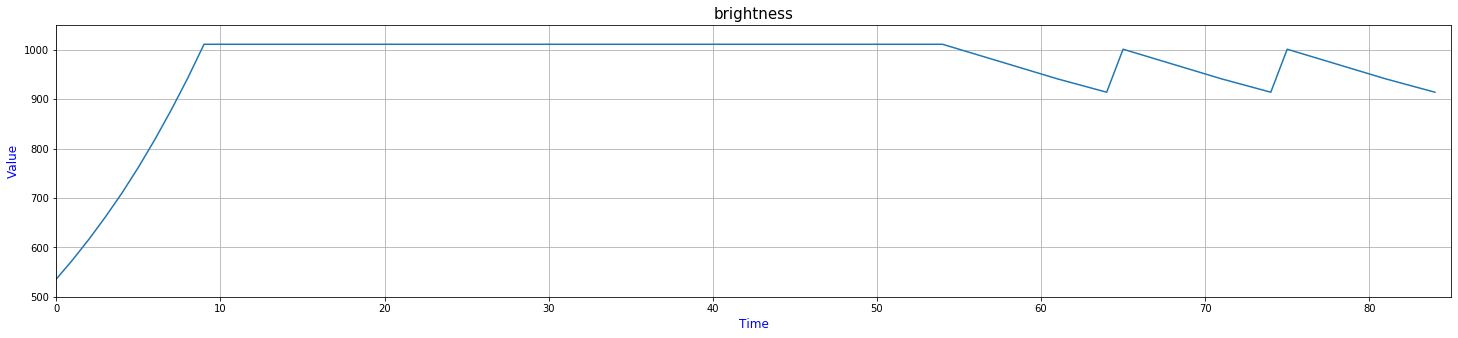

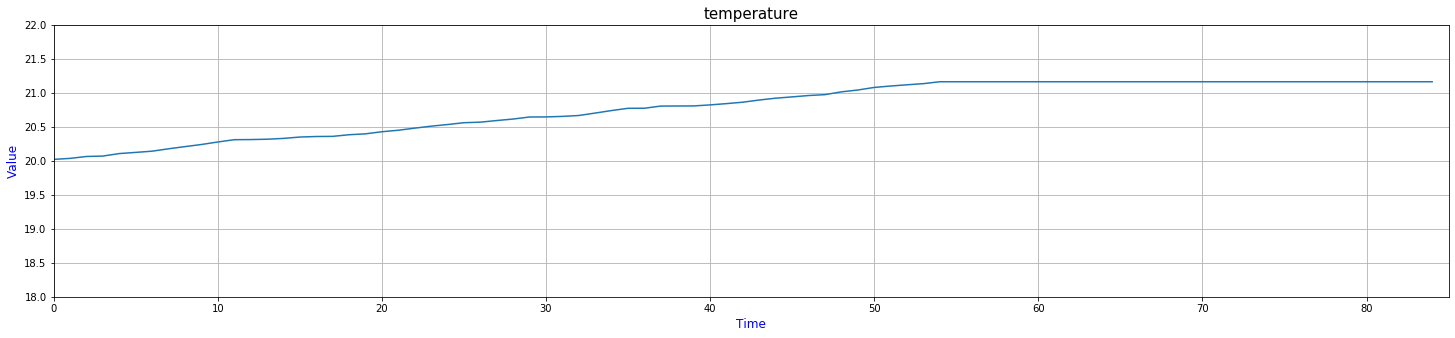

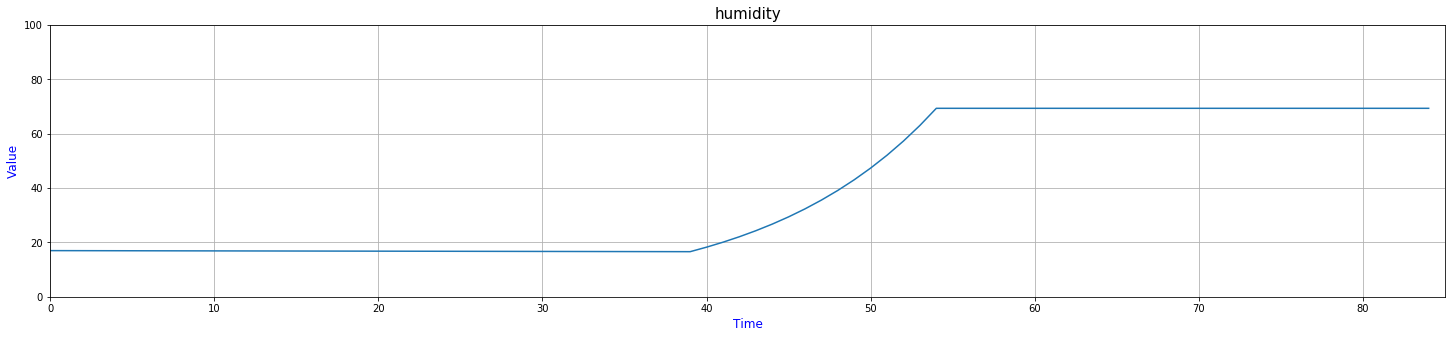

In [6]:
brightness = list(df['brightness'])
temperature = list(df['temperature'])
humidity = list(df['humidity'])

def plotting(brightness, a1, a2, text):
    fig = plt.figure(figsize=(25, 5))
    ax = fig.add_subplot(111)

    ax.set_xlim([0, len(brightness)])
    ax.set_ylim([a1, a2])

    ax.plot(brightness)

    plt.title(text, fontsize=15)
    plt.xlabel('Time', fontsize=12, color='blue')
    plt.ylabel('Value', fontsize=12, color='blue')
    plt.grid(True)

    plt.show()

plotting(brightness, 500, 1050, "brightness")
plotting(temperature, 18, 22, 'temperature')
plotting(humidity, 0, 100, 'humidity')

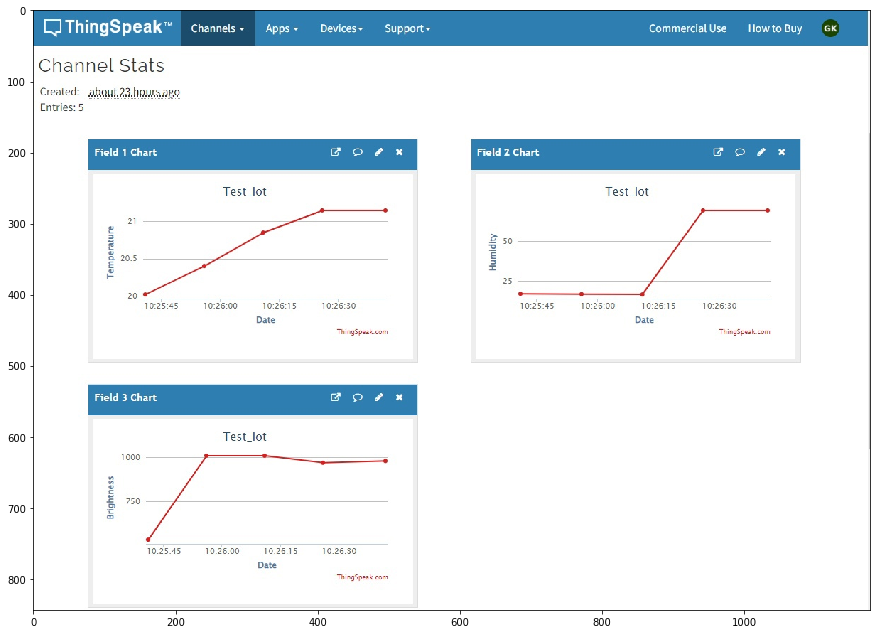

In [9]:
import numpy as np
import matplotlib.pyplot as plt

#  cbook - модуль "всяких полезностей":
import matplotlib.cbook as cbook

#  Конструкция "with ... as" гарантирует, что файл
#  будет закрыт после прочтения:
with cbook.get_sample_data('D:\Sunny\kaggle_contests\IoT course\pictures\pic1.jpg') as image_file:
    image = plt.imread(image_file)

fig, ax = plt.subplots()

ax.imshow(image)
#ax.set_title(type(image))

fig.set_figwidth(15)    #  ширина и
fig.set_figheight(15)    #  высота "Figure"

plt.show()

Растению холодно, его переставили

In [17]:
################################## VARIABLES ##################################
default_temperature = 10
default_brightness = 500
default_humidity = 17
default_watering_day = '2021-11-10'
pump_state = 0
lamp_state = 0

#main(pump_state, lamp_state, default_temperature, default_humidity, default_brightness, default_watering_day, False)

while(check_state(default_temperature, default_brightness, default_humidity) != 1):
    res = main(pump_state, lamp_state, default_temperature, default_humidity, default_brightness, default_watering_day, False)
    default_temperature = res[0]
    default_brightness = res[1]
    default_humidity = res[2]
    default_watering_day = res[3]
    pump_state = res[4]
    lamp_state = res[5]

Admin: Checking the light
Admin: Lamp is working
Adming: Checking the water
Admin: Pump is working
It's too cold for your plant, replace it.
Admin: Checking the light
Admin: Lamp is working
It's too cold for your plant, replace it.
Your plant is OK. Enjoy your day! =)


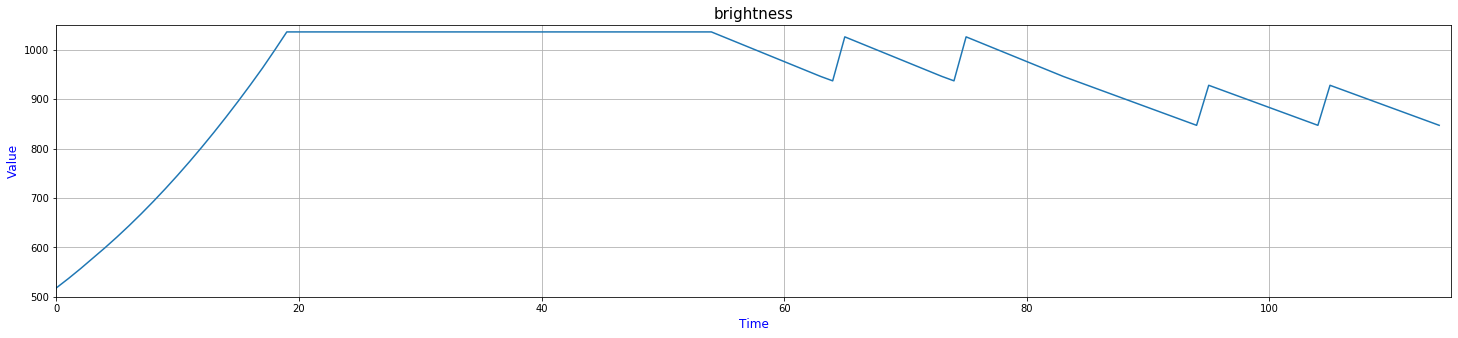

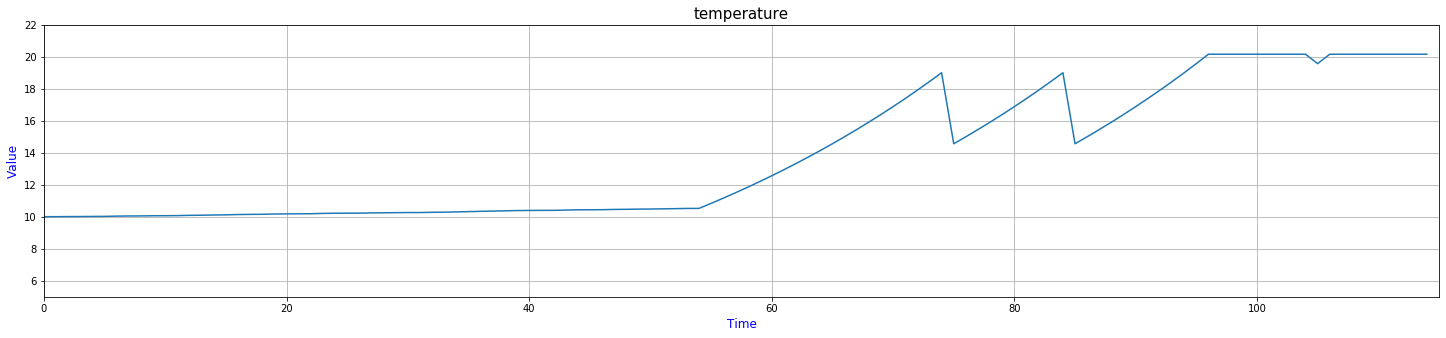

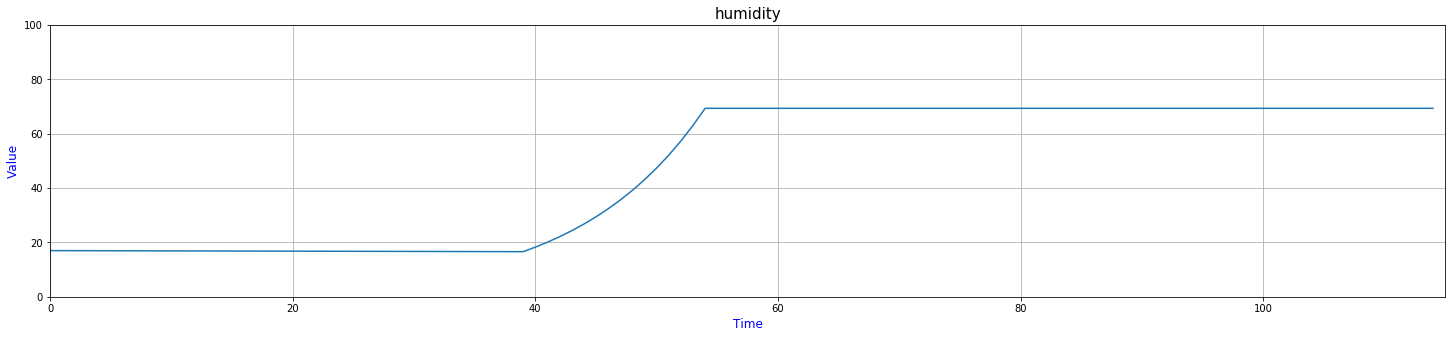

In [10]:
import pandas as pd 

df = pd.read_csv('data_csv_2.csv', sep=',', names=['date', 'time', 'brightness', 'temperature', 'humidity'])
brightness = list(df['brightness'])
temperature = list(df['temperature'])
humidity = list(df['humidity'])

def plotting(brightness, a1, a2, text):
    fig = plt.figure(figsize=(25, 5))
    ax = fig.add_subplot(111)

    ax.set_xlim([0, len(brightness)])
    ax.set_ylim([a1, a2])

    ax.plot(brightness)

    plt.title(text, fontsize=15)
    plt.xlabel('Time', fontsize=12, color='blue')
    plt.ylabel('Value', fontsize=12, color='blue')
    plt.grid(True)

    plt.show()

plotting(brightness, 500, 1050, "brightness")
plotting(temperature, 5, 22, 'temperature')
plotting(humidity, 0, 100, 'humidity')

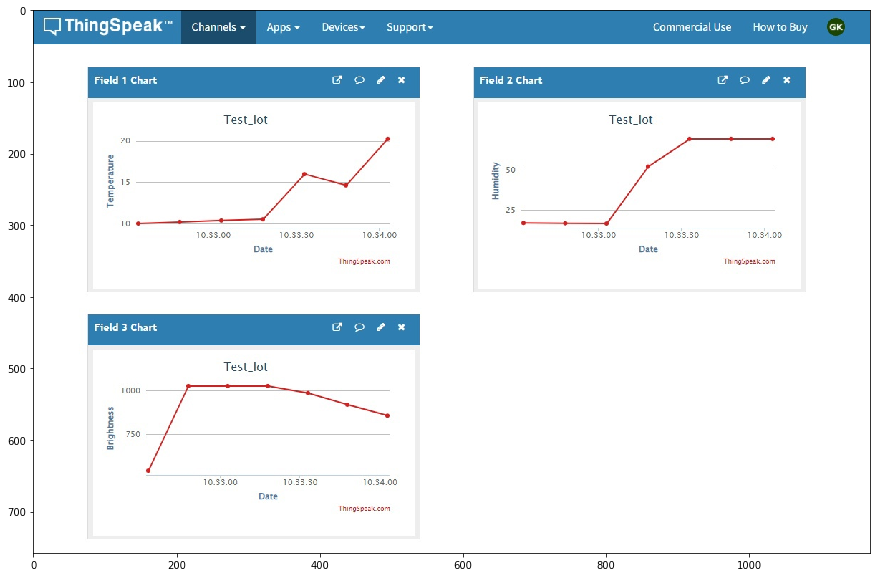

In [10]:
import numpy as np
import matplotlib.pyplot as plt

#  cbook - модуль "всяких полезностей":
import matplotlib.cbook as cbook

#  Конструкция "with ... as" гарантирует, что файл
#  будет закрыт после прочтения:
with cbook.get_sample_data('D:\Sunny\kaggle_contests\IoT course\pictures\pic2.jpg') as image_file:
    image = plt.imread(image_file)

fig, ax = plt.subplots()

ax.imshow(image)
#ax.set_title(type(image))

fig.set_figwidth(15)    #  ширина и
fig.set_figheight(15)    #  высота "Figure"

plt.show()

Анатолию капец как жарко, спасите его

In [4]:
################################## VARIABLES ##################################
default_temperature = 30
default_brightness = 500
default_humidity = 17
default_watering_day = '2021-11-10'
pump_state = 0
lamp_state = 0

#main(pump_state, lamp_state, default_temperature, default_humidity, default_brightness, default_watering_day, False)

while(check_state(default_temperature, default_brightness, default_humidity) != 1):
    res = main(pump_state, lamp_state, default_temperature, default_humidity, default_brightness, default_watering_day, False)
    default_temperature = res[0]
    default_brightness = res[1]
    default_humidity = res[2]
    default_watering_day = res[3]
    pump_state = res[4]
    lamp_state = res[5]

Admin: Checking the light
Admin: Lamp is working
Adming: Checking the water
Admin: Pump is working
It's too hot for your plant, replace it.
Your plant is OK. Enjoy your day! =)


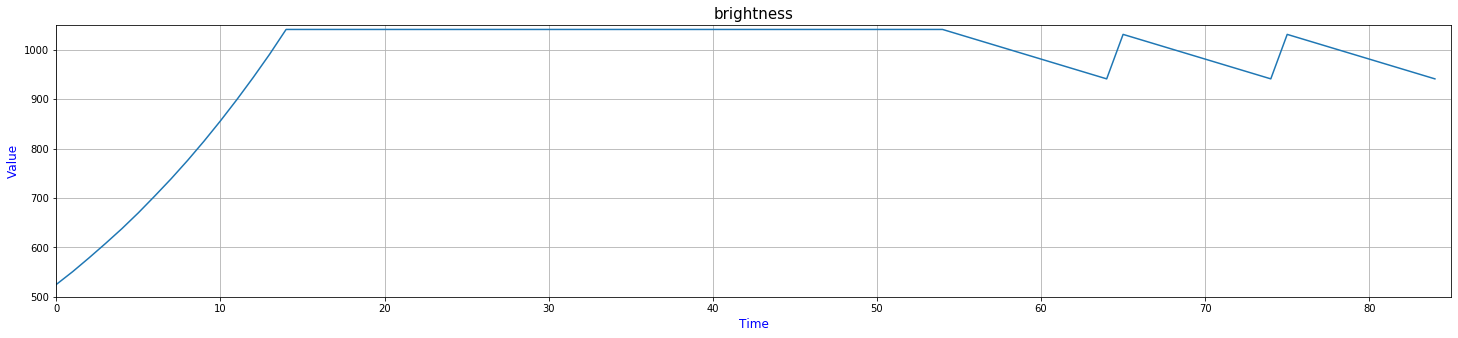

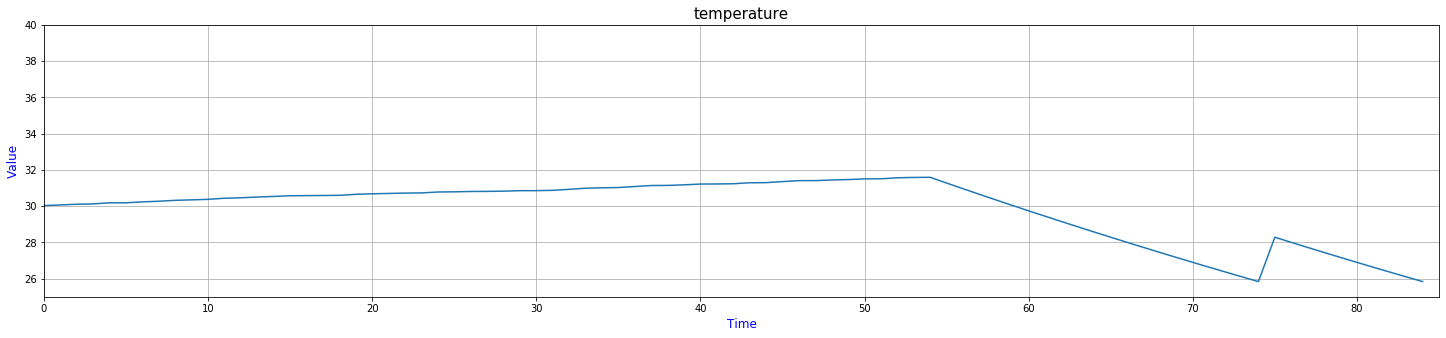

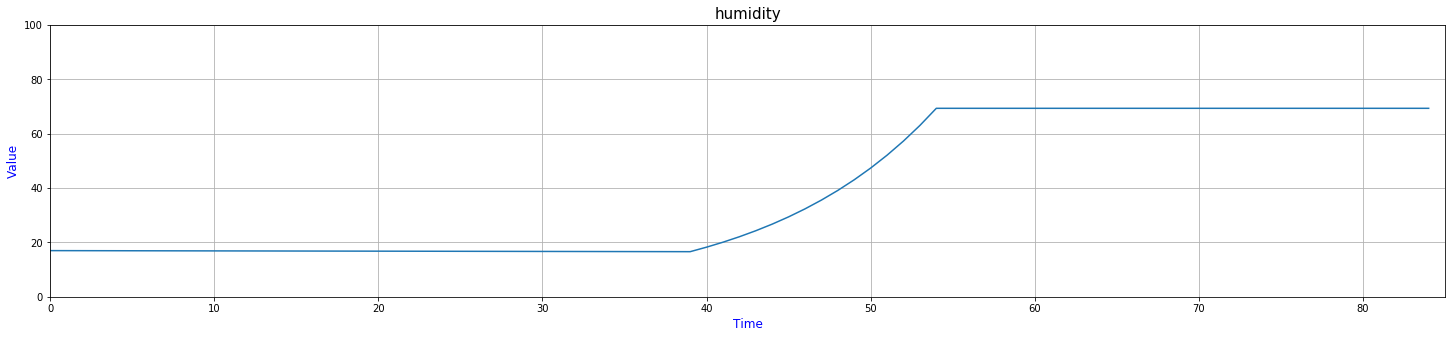

In [14]:
import pandas as pd 

df = pd.read_csv('data_csv_3.csv', sep=',', names=['date', 'time', 'brightness', 'temperature', 'humidity'])
brightness = list(df['brightness'])
temperature = list(df['temperature'])
humidity = list(df['humidity'])

def plotting(brightness, a1, a2, text):
    fig = plt.figure(figsize=(25, 5))
    ax = fig.add_subplot(111)

    ax.set_xlim([0, len(brightness)])
    ax.set_ylim([a1, a2])

    ax.plot(brightness)

    plt.title(text, fontsize=15)
    plt.xlabel('Time', fontsize=12, color='blue')
    plt.ylabel('Value', fontsize=12, color='blue')
    plt.grid(True)

    plt.show()

plotting(brightness, 500, 1050, "brightness")
plotting(temperature, 25, 40, 'temperature')
plotting(humidity, 0, 100, 'humidity')

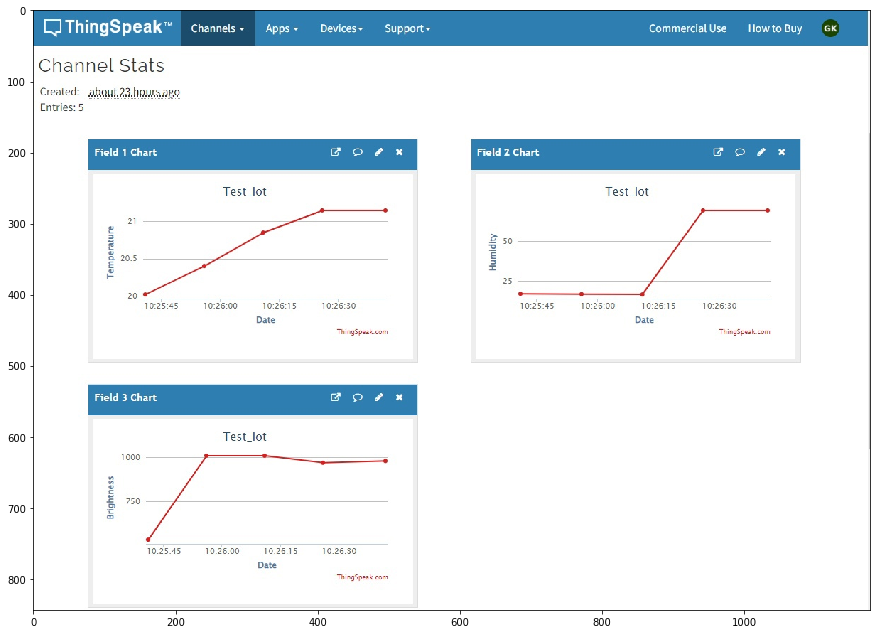

In [11]:
import numpy as np
import matplotlib.pyplot as plt

#  cbook - модуль "всяких полезностей":
import matplotlib.cbook as cbook

#  Конструкция "with ... as" гарантирует, что файл
#  будет закрыт после прочтения:
with cbook.get_sample_data('D:\Sunny\kaggle_contests\IoT course\pictures\pic1.jpg') as image_file:
    image = plt.imread(image_file)

fig, ax = plt.subplots()

ax.imshow(image)
#ax.set_title(type(image))

fig.set_figwidth(15)    #  ширина и
fig.set_figheight(15)    #  высота "Figure"

plt.show()

# Генератор json файла

In [18]:
import csv
import json
import pandas as pd

def csv_to_json(filename, outname):
    keys = ('date','time','brigthness','temperature','humidity')
    df = pd.read_csv(filename, names=list(keys))
    
    csvfile = open(filename, 'r')
    jsonfile = open(outname, 'w')
    jsonfile.write('{\n')
    jsonfile.write('\t\"Data\": {\n')

    reader = csv.DictReader(csvfile, keys)
    records = 0
    for row in reader:
        records += 1
        if records != 1:
            jsonfile.write('\t\t\"record ' + str(records-1) + "\": [\n")
            jsonfile.write('\t\t\t')
            
            json.dump(row, jsonfile, separators=[',\n\t\t\t',':'])
            if(records < len(df[keys[0]])):
                jsonfile.write('],\n')
            else:
                jsonfile.write(']\n')

    jsonfile.write('\t} \n')
    jsonfile.write('}')
    
csv_to_json('data_csv_1.csv', 'data_json_1_edited.json')
csv_to_json('data_csv_2.csv', 'data_json_2_edited.json')
csv_to_json('data_csv_3.csv', 'data_json_3_edited.json')

# Парсер

In [12]:
import csv

def csv_to_xml(csvFile, xmlFile):
	csvData = csv.reader(open(csvFile))
	xmlData = open(xmlFile, 'w')
	xmlData.write('<?xml version="1.0"?>' + "\n")
	# there must be only one top-level tag
	xmlData.write('<csv_data>' + "\n")

	rowNum = 0
	for row in csvData:
		if rowNum == 0:
			tags = row
			# replace spaces w/ underscores in tag names
			for i in range(len(tags)):
				tags[i] = tags[i].replace(' ', '_')
		else: 
			xmlData.write('<row>' + "\n")
			for i in range(len(tags)):
				xmlData.write('    ' + '<' + tags[i] + '>' \
							+ row[i] + '</' + tags[i] + '>' + "\n")
			xmlData.write('</row>' + "\n")
				
		rowNum +=1

	xmlData.write('</csv_data>' + "\n")
	xmlData.close()
 
csv_to_xml('data_csv_1.csv', 'data_xml_1.xml')
csv_to_xml('data_csv_2.csv', 'data_xml_2.xml')
csv_to_xml('data_csv_3.csv', 'data_xml_3.xml')